In [1]:
import numpy as np
import os,sys,time
import torch
import importlib

import options
from util import log, move_to_device
from options import set as set_option

import yaml
from easydict import EasyDict as edict
from matplotlib import pyplot as plt

import importlib
import numpy as np
import imageio

In [59]:
def image_float_to_uint8(img):
    """
    Convert a float image (0.0-1.0) to uint8 (0-255)
    """
    #print(img.shape)
    img = np.maximum(img, 0)
    img *= 255.0
    img = np.minimum(img, 255)
    return img.astype(np.uint8)

def imshow(torch_img, title=None):
    if len(torch_img.shape) == 4:
        torch_img = torch_img.squeeze(0)
    if torch_img.shape[0] == 3:
        torch_img = torch_img.permute(1,2,0)
    plt.imshow(torch_img.detach().cpu().numpy())
    if title != None:
        plt.title(str(title))
    plt.show()

In [48]:
args = {}
args['model'] = 'barf'
args['yaml'] = 'barf_freiburg_cars'
args['data']= {}
args['data']['scene'] = 'car001'
args['gpu'] = 0
args['group'] = 'freiburg_cars'
args['name'] = 'car001_barf_pe_lr_test'
args['resume'] = True
#args['load'] = '5000.ckpt'
args = edict(args)
opt = set_option(args)

setting configurations...
loading options/base.yaml...
loading options/nerf_freiburg_cars.yaml...
loading options/barf_freiburg_cars.yaml...
* H: 90
* W: 160
* arch:
   * density_activ: softplus
   * layers_feat: [None, 256, 256, 256, 256, 256, 256, 256, 256]
   * layers_rgb: [None, 128, 3]
   * posenc:
      * L_3D: 10
      * L_view: 4
   * skip: [4]
   * tf_init: True
* barf_c2f: None
* batch_size: None
* camera:
   * model: perspective
   * ndc: False
   * noise: None
* cpu: False
* data:
   * augment:
   * bgcolor: 1
   * center_crop: None
   * dataset: freiburg_cars
   * image_size: [90, 160]
   * num_workers: 4
   * preload: True
   * root: None
   * scene: car001
   * train_sub: None
   * val_on_test: False
   * val_ratio: 0.1
   * val_sub: 4
* device: cuda:0
* freq:
   * ckpt: 5000
   * scalar: 200
   * val: 2000
   * vis: 1000
* gpu: 0
* group: freiburg_cars
* load: None
* loss_weight:
   * render: 0
   * render_fine: None
* max_epoch: None
* max_iter: 200000
* model: barf
* 

In [49]:
model = importlib.import_module("model.{}".format(opt.model))
m = model.Model(opt)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/wbjang/anaconda3/envs/code_nerf/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [50]:
m.load_dataset(opt)
m.build_networks(opt)
m.setup_optimizer(opt)

loading training data...
True


number of samples: 117
loading test data...
True


number of samples: 4
building networks...


setting up optimizers...


In [51]:
m.restore_checkpoint(opt)
#m.setup_visualizer(opt)

resuming from previous checkpoint...
restoring nerf...
restoring se3_refine...
restoring optim...
restoring sched...
restoring optim_pose...
restoring sched_pose...
resuming from epoch None (iteration 200000)


In [52]:
# saved_path = 'output/freiburg_cars/' + args['name'] + '/train_renders/200K'
# print(saved_path)
# os.makedirs(saved_path, exist_ok=True)
# H, W = 90, 160

In [53]:
m.train_loader = m.train_data.setup_loader(opt, shuffle = False)

number of samples: 117


In [55]:
poses = []
poses_gt = []
imgs = []
imgs_gt = []
with torch.no_grad():
    for num, d in enumerate(m.train_loader):
        tempout = torch.zeros(H , 2*W, 3)
        d = edict(d)
        d = move_to_device(d, device=opt.device)
        pose = m.graph.get_pose(opt, d, mode='train')
        intr = d.intr
        poses.append(pose)
        poses_gt.append(d.pose)
        ret = m.graph.render(opt, pose, intr)
        imgs.append(ret.rgb.reshape(1,H,W,3))
        imgs_gt.append(d.image.reshape(1,3,H,W).permute(0,2,3,1))
        # tempout[:, :W, :] = ret.rgb.reshape(H,W,3)
        # tempout[:, W:, :] = d.image.reshape(3,H,W).permute(1,2,0)
        # strnum = str(num)
        # saveimgpath = os.path.join(saved_path, '0' * (3 - len(strnum)) + strnum + '.png')
        # imageio.imwrite(saveimgpath, image_float_to_uint8(tempout.detach().cpu().numpy()))
        # if num % 20 == 0:
        #     print(num, saveimgpath)
        

In [56]:
imgs = torch.cat(imgs)
imgs_gt = torch.cat(imgs_gt)
poses = torch.cat(poses)
poses_gt = torch.cat(poses_gt)

In [57]:
def imshow(torch_img, title=None):
    if len(torch_img.shape) == 4:
        torch_img = torch_img.squeeze(0)
    if torch_img.shape[0] == 3:
        torch_img = torch_img.permute(1,2,0)
    plt.imshow(torch_img.detach().cpu().numpy())
    if title != None:
        plt.title(str(title))
    plt.show()

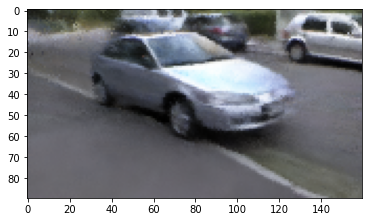

In [60]:
imshow(imgs[24])

In [62]:
poses[24], torch.trace(poses[24])

(tensor([[ 0.9856, -0.1649, -0.0384,  0.2548],
         [ 0.1637,  0.9859, -0.0336, -0.1364],
         [ 0.0434,  0.0268,  0.9987,  1.1596]], device='cuda:0'),
 tensor(2.9702, device='cuda:0'))

In [68]:
poses[24]

tensor([[ 0.9856, -0.1649, -0.0384,  0.2548],
        [ 0.1637,  0.9859, -0.0336, -0.1364],
        [ 0.0434,  0.0268,  0.9987,  1.1596]], device='cuda:0')

In [71]:
def get_axis_angle(R):
    theta = torch.acos((torch.trace(R) - 1) / 2)
    axis = torch.tensor([R[2,1] - R[1,2], R[0,2] - R[2,0], R[1,0] - R[0,1]]).type_as(R) / (torch.sin(theta) * 2)
    return axis, theta

In [73]:
axis, angle = get_axis_angle(poses[24])

In [76]:
torch.norm(axis), angle

(tensor(1.0000, device='cuda:0'), tensor(0.1729, device='cuda:0'))

In [77]:
axis

tensor([ 0.1757, -0.2379,  0.9553], device='cuda:0')

In [81]:
def perturb(axis):
    x, y = axis[0], axis[1]
    x_new = x + torch.randn(1).type_as(axis) * 1e-2
    y_new = y + torch.randn(1).type_as(axis) * 1e-2
    z_new = torch.sqrt(1 - x**2 - y**2).type_as(axis)
    return torch.tensor([x_new, y_new, z_new]).type_as(axis)

In [82]:
perturb(axis)

tensor([ 0.1670, -0.2297,  0.9553], device='cuda:0')

In [85]:
def get_cross_product_matrix(A):
    A_mat = torch.zeros(3,3)
    A_mat[0,1] = -A[2]
    A_mat[0,2] = A[1]
    A_mat[1,2] = -A[0]
    A_mat[1,0] = A[2]
    A_mat[2,0] = -A[1]
    A_mat[2,1] = A[0]
    return A_mat

def get_R(axis, angle):
    K = get_cross_product_matrix(axis).type_as(axis)
    R = torch.eye(3).type_as(axis) + torch.sin(angle).type_as(axis) * K + (1 - torch.cos(angle).type_as(axis)) * torch.matmul(K, K)
    return R

In [87]:
get_R(axis, angle), get_R(perturb(axis), angle)

(tensor([[ 0.9856, -0.1649, -0.0384],
         [ 0.1637,  0.9859, -0.0336],
         [ 0.0434,  0.0268,  0.9987]], device='cuda:0'),
 tensor([[ 0.9856, -0.1649, -0.0378],
         [ 0.1637,  0.9860, -0.0330],
         [ 0.0428,  0.0263,  0.9987]], device='cuda:0'))

In [93]:
imgs_perturbed = []
imgs_gt = []
with torch.no_grad():
    for num, d in enumerate(m.train_loader):
        tempout = torch.zeros(H , 2*W, 3)
        d = edict(d)
        d = move_to_device(d, device=opt.device)
        pose = m.graph.get_pose(opt, d, mode='train')
        RT, campos = pose[:, :3, :3] , pose[:,:3, 3:]
        #print(RT.shape)
        axis, angle = get_axis_angle(RT[0].transpose(-1,-2))
        intr = d.intr
        axis_new = perturb(axis)
        R_perturbed = get_R(axis_new, angle)
        pose_perturbed = torch.cat([R_perturbed.transpose(-1,-2).unsqueeze(0), campos], -1)
        #poses.append(pose)
        #poses_gt.append(d.pose)
        ret = m.graph.render(opt, pose_perturbed, intr)
        imgs_perturbed.append(ret.rgb.reshape(1,H,W,3))
        #imgs_gt.append(d.image.reshape(1,3,H,W).permute(0,2,3,1))

In [94]:
imgs_perturbed = torch.cat(imgs_perturbed)

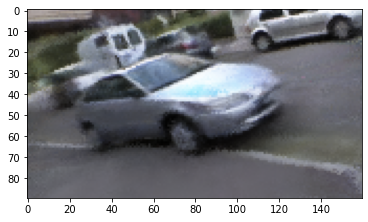

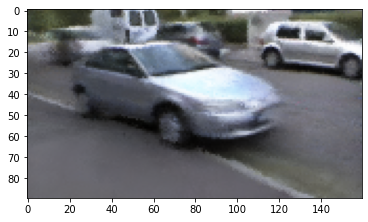

(None, None)

In [96]:
imshow(imgs_perturbed[20]), imshow(imgs[20])

In [98]:
R, T = poses[:, :3, :3], poses[:, :3, 3:]
R_gt, T_gt = poses_gt[:, :3, :3], poses_gt[:, :3, 3:]

In [101]:
torch.norm(T, dim=[1,2]), torch.norm(T_gt, dim=[1,2])

(tensor([0.6222, 0.6627, 0.7123, 0.7176, 0.7327, 0.7650, 0.6880, 0.7410, 0.8363,
         0.8541, 0.8320, 0.8402, 0.8938, 0.9974, 1.0085, 1.0893, 1.1922, 1.2306,
         1.2626, 1.3004, 1.3305, 1.3367, 1.2036, 1.1994, 1.1951, 0.9626, 0.9703,
         0.7243, 0.6878, 1.3764, 1.2543, 1.2413, 1.1937, 1.1655, 1.0518, 1.0396,
         0.8966, 0.8485, 0.7004, 0.6915, 1.0870, 1.0307, 0.9731, 0.8368, 0.7467,
         0.6236, 0.5705, 0.5553, 0.5525, 0.5491, 0.7672, 0.8330, 1.0632, 1.2432,
         1.2663, 1.2757, 1.2801, 1.2489, 1.0320, 1.0290, 1.0222, 0.8192, 0.8182,
         0.7827, 0.5639, 0.5596, 0.5598, 0.5599, 0.5697, 0.5765, 0.2541, 0.3060,
         0.4200, 0.4419, 0.2938, 0.2630, 0.5499, 0.5221, 0.5187, 0.5175, 0.5172,
         0.5165, 0.5220, 0.5364, 0.5449, 0.8201, 1.0912, 1.6997, 1.5620, 1.5257,
         1.5930, 1.5367, 1.4783, 1.4372, 1.4300, 1.4593, 1.4526, 1.3786, 1.5724,
         1.5200, 1.4886, 2.5449, 2.3822, 2.3023, 2.2247, 2.1931, 2.1386, 2.0468,
         2.0216, 1.9613, 1.9

In [102]:
T_norm = torch.norm(T, dim=[1,2])
T_norm_gt = torch.norm(T_gt, dim=[1,2])

Text(0.5, 1.0, 'Translation')

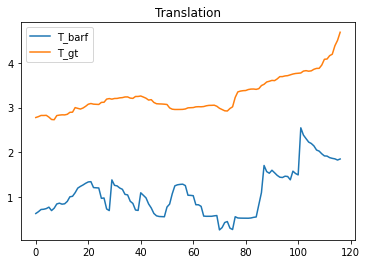

In [105]:
plt.plot(T_norm.detach().cpu())
plt.plot(T_norm_gt.detach().cpu())
plt.legend(['T_barf', 'T_gt'])
plt.title('Translation')

In [31]:
R1, R1_gt = R[:1], R_gt[:1]
R_rel = torch.matmul(R1.transpose(-1,-2), R)
R_rel_gt = torch.matmul(R1_gt.transpose(-1,-2), R_gt)

In [38]:
R_rel[1], R_rel_gt[1]

(tensor([[ 9.9976e-01, -7.9191e-04, -2.1874e-02],
         [ 7.3935e-04,  1.0000e+00, -2.4109e-03],
         [ 2.1876e-02,  2.3941e-03,  9.9976e-01]], device='cuda:0'),
 tensor([[ 0.6596, -0.0023, -0.0014],
         [ 0.0023,  1.0000,  0.5835],
         [ 0.0014,  0.5833,  1.0000]], device='cuda:0'))

In [13]:
files = [os.path.join(saved_path, f.name) for f in os.scandir(saved_path)]
imgs = []
for f in np.sort(files):
    imgs.append(imageio.imread(f, pilmode='RGB'))

In [14]:
imageio.mimwrite('barf_freiburg_full_pe_200k.mp4', imgs, fps=2, quality=7)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (320, 90) to (320, 96) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [15]:
m.graph

Graph(
  (nerf): NeRF(
    (mlp_feat): ModuleList(
      (0): Linear(in_features=63, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): Linear(in_features=319, out_features=256, bias=True)
      (5): Linear(in_features=256, out_features=256, bias=True)
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): Linear(in_features=256, out_features=257, bias=True)
    )
    (mlp_rgb): ModuleList(
      (0): Linear(in_features=283, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=3, bias=True)
    )
  )
  (se3_refine): Embedding(117, 6)
)

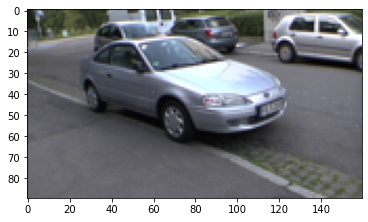

In [40]:
with torch.no_grad():
    for num, d in enumerate(m.train_loader):
        tempout = torch.zeros(H , 2*W, 3)
        d = edict(d)
        d = move_to_device(d, device=opt.device)
        pose = m.graph.get_pose(opt, d, mode='train')
        intr = d.intr
        ret = m.graph.render(opt, pose, intr)
        tempout[:, :W, :] = ret.rgb.reshape(H,W,3)
        tempout[:, W:, :] = d.image.reshape(3,H,W).permute(1,2,0)
        strnum = str(num)
        saveimgpath = os.path.join(saved_path, '0' * (3 - len(strnum)) + strnum + '.png')
        imageio.imwrite(saveimgpath, image_float_to_uint8(tempout.detach().cpu().numpy()))
        if num % 20 == 0:
            print(num, saveimgpath)

In [8]:
# get the external pose, camera intrinsic
d = edict(d)
d = move_to_device(d, device=opt.device)
pose = m.graph.get_pose(opt, d, mode='train')
intr = d.intr

In [10]:
with torch.no_grad():
    ret = m.graph.render(opt, pose, intr)

In [12]:
ret.keys()

dict_keys(['rgb', 'depth', 'opacity'])

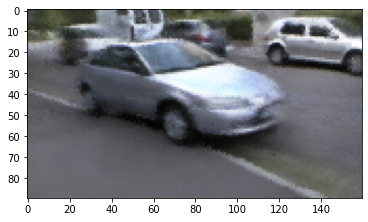

In [15]:
plt.imshow(ret.rgb.detach().cpu().reshape(90,160,3))

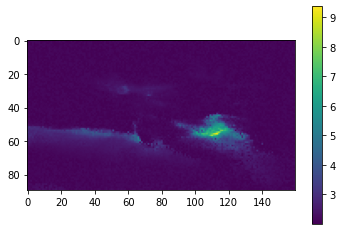

In [23]:
plt.imshow(ret.depth.detach().cpu().reshape(90,160))
plt.colorbar()

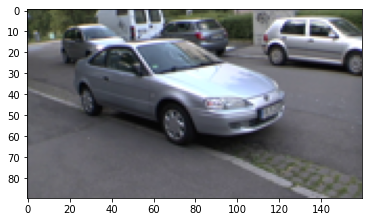

In [21]:
plt.imshow(d.image.permute(0,2,3,1).detach().cpu()[0])

In [18]:
d.image.shape

torch.Size([1, 3, 90, 160])